# install

```
sudo add-apt-repository ppa:openscad/releases
sudo apt-get update
sudo apt-get install openscad

pip install solidpython2 jupyterscad matplotlib hilbertcurve
```

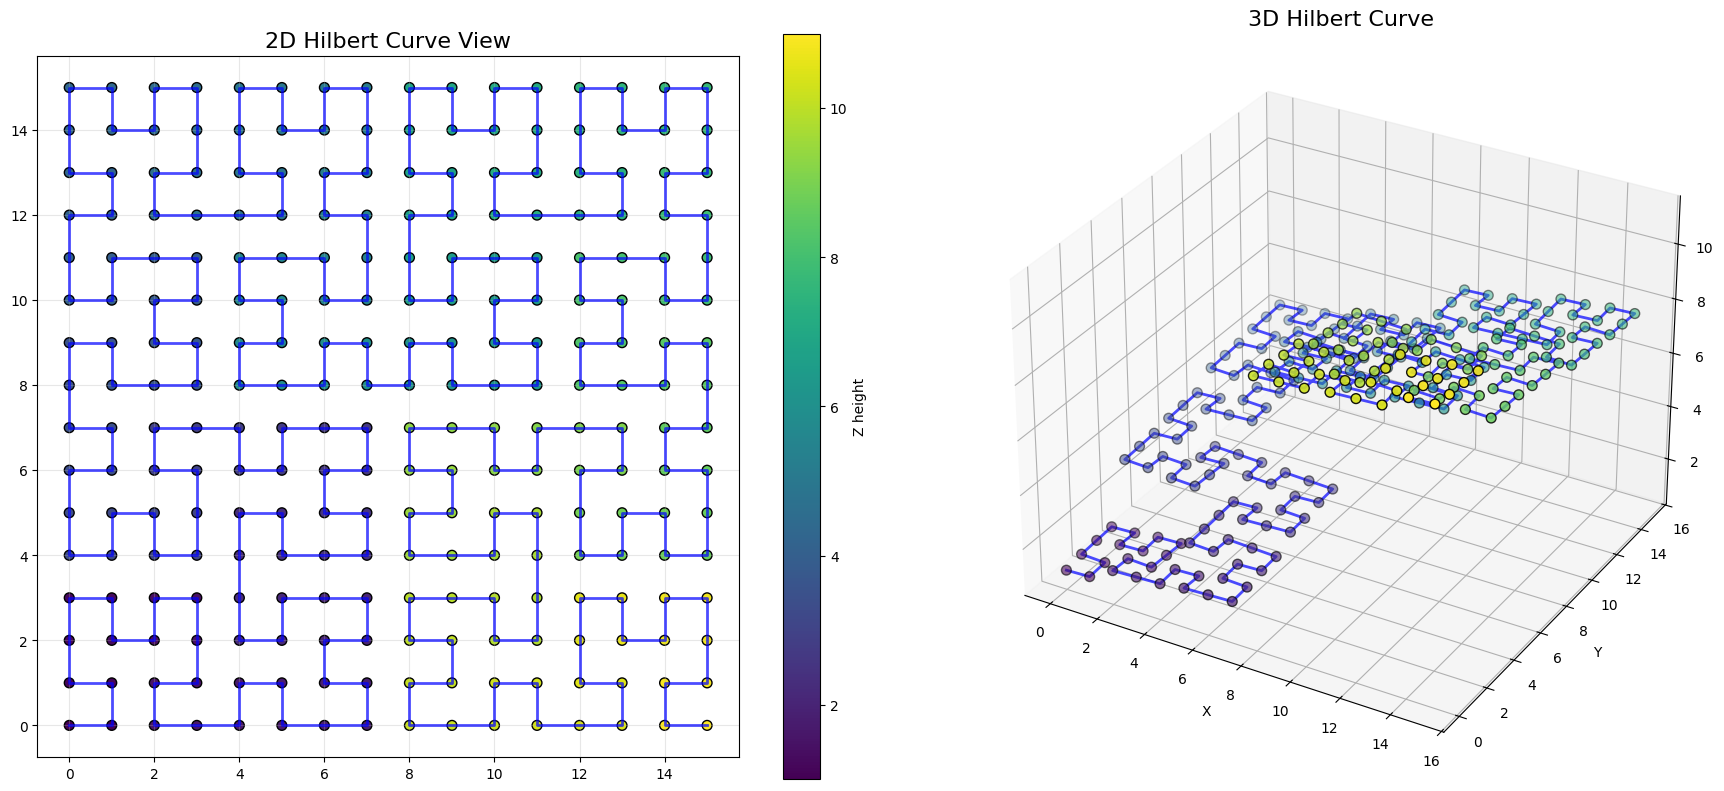

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from hilbertcurve.hilbertcurve import HilbertCurve

def get_hilbert_3d_curve(order, spacing:float, z_size: float, z_offset: float):
    dimensions = 2
    hilbert_curve = HilbertCurve(order, dimensions)
    distances_along_curve = list(range(2 ** (dimensions * order)))
    points = hilbert_curve.points_from_distances(distances_along_curve)
    # Convert list of points to a numpy array
    points = np.array(points, dtype=float)

    points *= spacing
    # Generate z coordinates with size and offset
    z_coords = np.linspace(z_offset, z_offset + z_size, len(points))
    
    # Create a single numpy array of shape (n, 3)
    return np.column_stack((points, z_coords))

points = get_hilbert_3d_curve(4, spacing=1, z_size=10, z_offset=1)
    

def plot_hilbert_curve(points, connect_points=True, show_points=True):
    """
    Plot a Hilbert curve from the given points in both 2D and 3D.
    
    Args:
        points (ndarray): Nx3 array of points (x, y, z)
        connect_points (bool): Whether to connect points with lines
        show_points (bool): Whether to display the individual points
    """
    # Extract coordinates from the points array
    x_coords = points[:, 0]
    y_coords = points[:, 1]
    z_coords = points[:, 2]
    
    # Create a figure with two subplots (2D and 3D)
    fig = plt.figure(figsize=(18, 8))
    
    # 2D plot
    ax1 = fig.add_subplot(121)
    
    # Plot the curve (connected points) in 2D
    if connect_points:
        ax1.plot(x_coords, y_coords, '-', linewidth=2, color='blue', alpha=0.7)
    
    # Plot the individual points in 2D
    if show_points:
        scatter = ax1.scatter(x_coords, y_coords, s=50, c=z_coords, cmap='viridis', edgecolors='black')
    
    # Customize the 2D plot
    ax1.set_title('2D Hilbert Curve View', fontsize=16)
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal')
    fig.colorbar(scatter, ax=ax1, label='Z height')
    
    # 3D plot
    ax2 = fig.add_subplot(122, projection='3d')
    
    # Plot the curve (connected points) in 3D
    if connect_points:
        ax2.plot(x_coords, y_coords, z_coords, '-', linewidth=2, color='blue', alpha=0.7)
    
    # Plot the individual points in 3D
    if show_points:
        ax2.scatter(x_coords, y_coords, z_coords, s=50, c=z_coords, cmap='viridis', edgecolors='black')
    
    # Customize the 3D plot
    ax2.set_title('3D Hilbert Curve', fontsize=16)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    
plot_hilbert_curve(points)


In [26]:
# demo showing how to use jupyterscad
from jupyterscad import view
from solid2 import cube

view(cube([1.5,2,1],center=True), outfile='cube.stl')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.7, position=(3.0, 5.0,…

In [28]:
# Creates the underlying support structure for the marble track.
import math
import numpy as np
from solid2 import cube, cylinder, union, translate, rotate, color, sphere
from solid2 import polyhedron


def create_support_structure(points, w):
    supports = []
    
    for i, point in enumerate(points):
        x, y, z = point
        
        # Create vertical cylinder from ground (z=0) to point height (z)
        vertical_cylinder = translate([x, y, 0])(
            cylinder(d=w, h=z, _fn=20)
        )
        supports.append(vertical_cylinder)
        
        # Create connecting polyhedron to next point (if not the last point)
        if i < len(points) - 1:
            next_point = points[i + 1]
            next_x, next_y, next_z = next_point
            
            # Calculate the vector from current point to next point
            dx = next_x - x
            dy = next_y - y
            dz = next_z - z
            
            # Calculate the angle for rotation in XY plane
            angle = math.degrees(math.atan2(dy, dx))
            
            # Calculate the distance (length) between points in XY plane
            horizontal_distance = math.sqrt(dx**2 + dy**2)
            
            # Define the half-width of the polyhedron
            half_w = w / 2
            
            # Create points for the polyhedron (8 vertices)
            # Bottom face at current point
            p1 = [0, -half_w, 0]
            p2 = [0, half_w, 0]
            p3 = [horizontal_distance, half_w, 0]
            p4 = [horizontal_distance, -half_w, 0]
            
            # Top face sloped from current z to next z
            p5 = [0, -half_w, z]
            p6 = [0, half_w, z]
            p7 = [horizontal_distance, half_w, z + dz]  # Use absolute height (z + dz)
            p8 = [horizontal_distance, -half_w, z + dz]  # Use absolute height (z + dz)
            
            # Define the faces of the polyhedron using correct winding order
            # Each face must have vertices specified in counterclockwise order when viewed from outside
            faces = [
                [0, 3, 2, 1],  # Bottom face
                [4, 5, 6, 7],  # Top face
                [0, 1, 5, 4],  # Front face
                [1, 2, 6, 5],  # Right face 
                [2, 3, 7, 6],  # Back face
                [3, 0, 4, 7]   # Left face
            ]
            
            # Create the polyhedron and position/rotate it
            connecting_poly = translate([x, y, 0])(
                rotate([0, 0, angle])(
                    polyhedron(
                        points=[p1, p2, p3, p4, p5, p6, p7, p8],
                        faces=faces
                    )
                )
            )
            supports.append(connecting_poly)
            
    # Combine all the parts into a single union
    return union()(*supports)
support = create_support_structure(points, .85)
view(support)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.7, position=(3.0, 5.0,…

In [ ]:
# connecting material to cut filament use between tracks
from solid2 import cube, union

def create_blocks(points):
    # Calculate how many blocks we need
    num_points = len(points)

    # 32, 16 works great
    # 64, 64 good
    # 256, 256 fills in a nice basement
    # 64, 16 -> artifacts
    blocks = []
    
    # sliding window
    block_steps = [
        (32, 16),  # 32 points per block, 16 points step
        (64, 64),  # 64 points per block, 64 points step
        (128, 64),
        (256, 256) # 256 points per block, 256 points step
    ]
    for block_size, step_size in block_steps:
        for start_idx in range(0, num_points, step_size):
            # Get the next group of 16 points (or fewer for the last group)
            end_idx = min(start_idx + block_size, num_points)
            group_points = points[start_idx:end_idx]
            
            if len(group_points) > 0:
                # Find the min/max x,y coordinates in this group
                min_x = min(point[0] for point in group_points)
                max_x = max(point[0] for point in group_points)
                min_y = min(point[1] for point in group_points)
                max_y = max(point[1] for point in group_points)
                
                # Find the lowest z coordinate in this group
                min_z = min(point[2] for point in group_points)
                
                # Create a rectangular block
                width = max_x - min_x
                depth = max_y - min_y
                height = min_z
                
                if width > 0 and depth > 0 and height > 0:
                    block = translate([min_x, min_y, 0])(
                        cube([width, depth, height])
                    )
                    blocks.append(block)
    
    # Combine all blocks into a single union
    return union()(*blocks)
blocks = create_blocks(points)
view(blocks | support, width=800, height=800)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.7, position=(3.0, 5.0,…

In [29]:
# channel creation
from solid2 import sphere, cylinder, union, translate, rotate

def create_channel(points, diameter, z_offset):
    channel_radius = diameter / 2
    # Create an empty union to hold all components
    channel = union()

    moved_pts = points.copy()
    moved_pts[:, 2] += z_offset
    
    # Create a sphere at each point
    for point in moved_pts:
        channel += translate(point)(sphere(r=channel_radius * 0.99, _fn=32))
    
    # Create cylinders between consecutive points
    for i in range(len(moved_pts) - 1):
        p1 = moved_pts[i]
        p2 = moved_pts[i + 1]
        
        # Calculate cylinder direction vector
        direction = p2 - p1
        height = np.linalg.norm(direction)
        
        # Create a cylinder between two points
        # We'll use a different approach to calculate the rotation
        
        # The default cylinder is along the Z-axis
        # We need to rotate it to align with our direction vector
        
        # Calculate the unit vector of our direction
        unit_vector = direction / height
        
        # The default cylinder orientation is along the z-axis (0, 0, 1)
        z_axis = np.array([0, 0, 1])
        
        # Calculate the rotation axis (perpendicular to both vectors)
        rotation_axis = np.cross(z_axis, unit_vector)
        
        # If vectors are parallel (or nearly so), set a default axis
        if np.linalg.norm(rotation_axis) < 1e-10:
            rotation_axis = np.array([1, 0, 0])
        else:
            rotation_axis = rotation_axis / np.linalg.norm(rotation_axis)
        
        # Calculate the rotation angle
        angle = np.degrees(np.arccos(np.clip(np.dot(z_axis, unit_vector), -1.0, 1.0)))
        
        # Create the cylinder
        cyl = translate(p1)(
            rotate(a=angle, v=rotation_axis)(
                cylinder(r=channel_radius, h=height, _fn=32)
            )
        )
        channel += cyl
    
    return channel

view(create_channel(points[:10], .5, z_offset=0.1), width=1000, height=1000)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.7, position=(3.0, 5.0,…

### Best stats so far
```
# is fine as long as you use fine print settings
z_size = 0.10 

# flatter channel settings work better to avoid getting stuck
chan_diam_ratio = 1.10
chan_offset_ratio = 0.4

```

In [31]:
# Put it all together

order = 4
n_points = 0
spacing = 0.008
z_size = 0.10

base_offset = 0.002
support_ratio = 0.90

chan_diam_ratio = 1.10
chan_offset_ratio = 0.4
pts = get_hilbert_3d_curve(order=order, spacing=spacing, z_size=z_size, z_offset=base_offset)
if n_points > 0:
    pts = pts[:n_points]

channel = create_channel(pts, diameter=spacing * chan_diam_ratio, z_offset=spacing * chan_offset_ratio)
support = create_support_structure(pts, w=spacing * support_ratio)
blocks = create_blocks(pts)
structure = (support | blocks) - channel
# structure = (support) - channel

# file_name = None
file_name = f"hilbert_sphere0.99_o{order}_n{len(pts)}_s{spacing}_z{z_size}_cd{chan_diam_ratio}_co{chan_offset_ratio}.stl"
    
view(structure, outfile=file_name, width=1200, height=1200)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.7, position=(3.0, 5.0,…